# COVID Weather Analysis Using Pyspark

## DS 5559 - Big Data Analytics - Final Project

### Authors
- Aubrey Brockmiller (alb3cb)
- Ian Kloo (ipk8gh)
- Shawn Michanco (sbm5rg)
- Akeem Wells (ajw3rg)

## 0. Loading in libraries and Setting up Spark

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GeneralizedLinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.window import Window
from pyspark.sql.functions import lead, lit, log, col
from pyspark.ml.feature import StandardScaler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

This was run on a big machine where I could allocate 100GB RAM to both the executor and driver.  You'll want to modify for your system specs.  

I changed from the defaults to avoid an issue I was having where the Java runtime only had access to a few GB RAM by default.

I am running on a single big machine instead of clusters due to available resources (not really the idea of Pyspark, I know...but its the hardware I have).

In [2]:
spark = SparkSession \
    .builder \
    .appName("covid weather") \
    .config('spark.executor.cores', '20') \
    .config("spark.executor.memory", '100g') \
    .config("spark.driver.memory", '100g') \
    .getOrCreate()

## 1. Data Import and Preprocessing

Source data is created in `r_data_acquisition.ipynb`.  See that notebook for details.

In [3]:
df = spark.read.csv('cov_weather_mobility.csv', inferSchema = True, header = True)

df.limit(5).toPandas()

,YEARMODA,FIPS,TEMP,PRCP,RH,VISIB,MXSPD,GUST,pop,deaths,case_count,infect_prob,seven_day_percap,r_t,doubling,per_delta,r_t_three,r_t_seven,m50_index
0,2020-03-01,1001,9.660000,0.0,57.400000,15.800000,5.900000,9.55,55869,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,49
1,2020-03-01,1003,13.260000,0.0,69.500000,15.766667,5.916667,10.50,223234,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,81
2,2020-03-01,1007,10.133333,0.0,50.850000,16.000000,4.850000,8.75,22394,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,53
3,2020-03-01,1009,8.350000,0.0,45.133333,16.100000,7.000000,9.55,57826,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,68
4,2020-03-01,1011,9.700000,0.0,NaN,NaN,5.300000,NaN,10101,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,70


In [4]:
df.count()

1221090

In [5]:
df.printSchema()

root
 |-- YEARMODA: string (nullable = true)
 |-- FIPS: integer (nullable = true)
 |-- TEMP: double (nullable = true)
 |-- PRCP: double (nullable = true)
 |-- RH: double (nullable = true)
 |-- VISIB: double (nullable = true)
 |-- MXSPD: double (nullable = true)
 |-- GUST: double (nullable = true)
 |-- pop: integer (nullable = true)
 |-- deaths: integer (nullable = true)
 |-- case_count: integer (nullable = true)
 |-- infect_prob: double (nullable = true)
 |-- seven_day_percap: double (nullable = true)
 |-- r_t: double (nullable = true)
 |-- doubling: integer (nullable = true)
 |-- per_delta: double (nullable = true)
 |-- r_t_three: double (nullable = true)
 |-- r_t_seven: double (nullable = true)
 |-- m50_index: integer (nullable = true)



We end up with a row for each county for each day with columns containing COVID-19 metrics, weather features, and mobility data.

### 1.1 Data Filtering and Outlier Removal

Subsetting to date range of interest:

In [6]:
df = df.filter(df.YEARMODA >= '2020-06-01')
df = df.filter(df.YEARMODA < '2021-03-01')

Some large outliers in mobility metric and infectious probaility.  Infectious probability outliers come from COVID data reporting issues.  From what I can see in the Google mobility project, there are similar strange outliers that come from the data collection methodology.  

In [7]:
df = df.filter(df.m50_index < 500)
df = df.filter(df.infect_prob < 100)
df = df.filter(df.infect_prob > 0)

We also want to drop any rows without infectious probability data since this is our dependent variable.  Again, these errors come from excentricities in the COVID-19 reporting data.

In [8]:
df = df.na.drop(subset = ['infect_prob'])

Down to ~660k rows after basic filtering.

In [9]:
df.count()

659299

### 1.2 Feature Engineering

#### 1.2.1 Leading Infectious Probability Variable

If there is a relationship between weather/mobility and COVID, we would expect a lag roughly equal to the incubation period of the virus.  We estimate this to be 7 days, which appears to be the median incubation period of SARS-COV-2.

We need to window by county (FIPS code) and maintain the date order.

In [10]:
df = df.withColumn("infect_prob_7day_lag",lead(df.infect_prob,7).over(Window.partitionBy("FIPS").orderBy("YEARMODA")))
#first few rows now null for infectprob after the lag
df = df.na.drop(subset = ['infect_prob_7day_lag'])

In [11]:
df.sort(['FIPS', 'YEARMODA']).select(['YEARMODA','FIPS','infect_prob','infect_prob_7day_lag']).limit(15).toPandas()

,YEARMODA,FIPS,infect_prob,infect_prob_7day_lag
0,2020-06-01,1001,1.3961,1.0023
1,2020-06-02,1001,1.4140,1.1097
2,2020-06-03,1001,1.1813,1.1097
3,2020-06-04,1001,0.9307,1.3245
4,2020-06-05,1001,1.0023,1.5035
5,2020-06-06,1001,0.9665,1.6109
6,2020-06-07,1001,0.9486,1.9510
7,2020-06-08,1001,1.0023,1.9510
8,2020-06-09,1001,1.1097,1.9331
9,2020-06-10,1001,1.1097,1.8436


As you can see here, our dependent variable (`infect_prob_7day_lag`) represents what the infectious probability will be 7 days in the future in a given county.  We are going to be predicting what happens in the future (7 days) given what we know now.

#### 1.2.2 Creating Scaled Feature Vector 

Now we need to select features and assemble them into a single vector column.

In [12]:
features = ['TEMP','PRCP','RH','VISIB','MXSPD','GUST','m50_index']

assembler = VectorAssembler(inputCols = features, outputCol = 'features', handleInvalid = 'skip')

df_feat = assembler.transform(df)
df_feat.select('features').limit(5).toPandas()

,features
0,"[10.9833333333333, 1.4, 65.26, 15.933333333333..."
1,"[11.7, 0.0, 59.16, 16.1, 6.45, 8.75, 95.0]"
2,"[10.5333333333333, 0.0, 62.04, 15.933333333333..."
3,"[9.78333333333333, 0.0, 72.16, 16.1, 7.15, 7.9..."
4,"[10.4833333333333, 0.0, 73.38, 16.1, 6.2666666..."


Next, we scale the features:

In [13]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
scale_mod = scaler.fit(df_feat)
df_scaled = scale_mod.transform(df_feat)

df_scaled.select('scaled_features').limit(5).toPandas()

,scaled_features
0,"[1.0260369569937462, 0.1865246484746155, 4.012..."
1,"[1.0929862576777116, 0.0, 3.637032929105424, 7..."
2,"[0.9839990240061418, 0.0, 3.814089298879319, 7..."
3,"[0.9139358023601375, 0.0, 4.436245709334811, 7..."
4,"[0.9793281425630748, 0.0, 4.51124875486403, 7...."


#### 1.2.3 Log Transform Dependent Variable to Reduce Heteroscedasticity 

In [14]:
df_scaled = df_scaled.withColumn("infect_prob_7day_lag", log(10.0,"infect_prob_7day_lag"))

## 2. Downsampling and Splitting into Test and Train

Due to the size of the data, we can downsample by half and still have ~210k rows.  In practice this sped up our grid search for tuning hyperparameters.

We need to stratify the downsampling by county to make sure we don't miss or overrepresent any areas.

In [15]:
fractions = df_scaled.select("FIPS").distinct().withColumn("fraction", lit(0.5)).rdd.collectAsMap()
df_scaled_sample = df_scaled.sampleBy("FIPS", fractions)

df_scaled_sample.count()

202899

Splitting to train/test sets:

In [16]:
train, test = df_scaled_sample.randomSplit([0.7, 0.3])

In [17]:
train.limit(5).toPandas()

,YEARMODA,FIPS,TEMP,PRCP,RH,VISIB,MXSPD,GUST,pop,deaths,...,seven_day_percap,r_t,doubling,per_delta,r_t_three,r_t_seven,m50_index,infect_prob_7day_lag,features,scaled_features
0,2020-06-01,2122,10.983333,1.4,65.26,15.933333,5.5,9.5,58708,2,...,37.4736,1.6009,16,0.0889,2.3134,4.2893,114,-0.115488,"[10.9833333333333, 1.4, 65.26, 15.933333333333...","[1.0260369569937462, 0.1865246484746155, 4.012..."
1,2020-06-01,12027,27.600000,0.0,72.10,16.100000,11.3,14.4,38001,7,...,171.0481,0.0000,12,0.0000,0.4025,1.3855,123,0.465532,"[27.6, 0.0, 72.1, 16.1, 11.3, 14.4, 123.0]","[2.5783265565730633, 0.0, 4.432557034964521, 7..."
2,2020-06-01,13285,24.600000,0.0,58.00,16.100000,7.2,9.3,69922,11,...,84.3797,0.6854,28,0.0192,1.1115,1.0779,84,0.375499,"[24.6, 0.0, 58.0, 16.1, 7.2, 9.3, 84.0]","[2.298073669989035, 0.0, 3.5657185579464947, 7..."
3,2020-06-01,31035,25.800000,0.0,48.70,16.100000,9.3,16.0,6203,0,...,32.2425,0.0000,20,0.0000,0.0000,0.4663,64,-0.315514,"[25.8, 0.0, 48.7, 16.1, 9.3, 16.0, 64.0]","[2.410174824622646, 0.0, 2.993974030551626, 7...."
4,2020-06-01,40011,23.600000,0.0,57.40,16.100000,7.7,10.8,9429,0,...,10.6056,0.0000,17,0.0000,0.0000,0.5292,91,-0.497300,"[23.6, 0.0, 57.4, 16.1, 7.7, 10.8, 91.0]","[2.204656041127692, 0.0, 3.5288318142435995, 7..."


## 3. Exploratory Data Analysis

### 3.1 Variable Exploration

In [18]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
YEARMODA,640619,None,None,2020-06-01,2021-02-21
FIPS,640619,30003.48583167218,15233.921581860035,1001,56041
TEMP,640619,14.548324569171156,11.043661675843401,-43.0333333333333,43.1
PRCP,621404,2.1661290039821934,6.796775806587351,0.0,230.9
RH,625601,68.87420946399914,15.751935954506086,5.425,100.0
VISIB,620173,14.829372014270705,2.3112631163955863,0.0,80.5
MXSPD,628680,6.375921174158577,2.5401767215850333,0.5,34.0
GUST,421656,11.123213766562825,3.2701738284378905,5.1,41.7
pop,640619,125738.7186611699,365205.139702166,169,10039107


Here we look at the (non-scaled) variables to see what our ranges are.  There is clearly some strange data in the COVID variables (see seven_day_percap), but we are not using these.  The weather variables all seem to represent reasonable ranges of values.  

### 3.2 Exploring Correlations

Looking at some correlations, it looks like temperature has some negative correlation with COVID-19 infection, but it isn't particularly strong.  Mobility also interestingly has a negative correlation.  This could be due to the fact that restrictions on movement tend to correspond with increased infections.  There is the potential for a causal loop with that variable - but we won't worry about that in this first modeling effort.  

In general, it appears there is relatively low correlation across the board between the independent and dependent variables.  This suggests there isn't a simple linear relationship that we are missing.

In [19]:
features = ['TEMP','PRCP','RH','VISIB','MXSPD','GUST','m50_index']
cor_df = pd.DataFrame(columns = ['variable', 'correlation_with_infectprob'])

for fe in features:
    cor_df = cor_df.append({'variable': fe, 'correlation_with_infectprob': df.stat.corr('infect_prob', fe)}, ignore_index=True)
    
cor_df

,variable,correlation_with_infectprob
0,TEMP,-0.381130
1,PRCP,-0.031166
2,RH,-0.004845
3,VISIB,-0.018617
4,MXSPD,0.088884
5,GUST,0.034845
6,m50_index,-0.114253


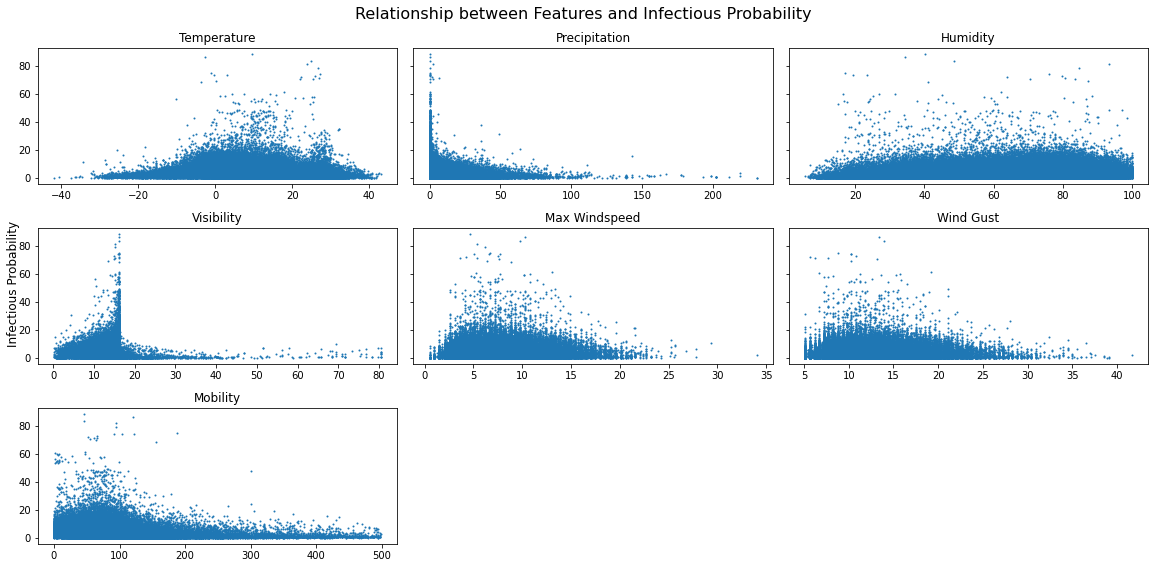

In [20]:
fractions = df.select("FIPS").distinct().withColumn("fraction", lit(0.5)).rdd.collectAsMap()
df_local = df.sampleBy("FIPS", fractions).toPandas()

fig, ax = plt.subplots(3, 3, figsize = (16, 8), sharey = True, sharex = False)
ax[0,0].scatter(df_local.TEMP, df_local.infect_prob, s = 1)
ax[0,0].set_title('Temperature')
ax[0,1].scatter(df_local.PRCP, df_local.infect_prob, s = 1)
ax[0,1].set_title('Precipitation')
ax[0,2].scatter(df_local.RH, df_local.infect_prob, s = 1)
ax[0,2].set_title('Humidity')
ax[1,0].scatter(df_local.VISIB, df_local.infect_prob, s = 1)
ax[1,0].set_title('Visibility')
ax[1,1].scatter(df_local.MXSPD, df_local.infect_prob, s = 1)
ax[1,1].set_title('Max Windspeed')
ax[1,2].scatter(df_local.GUST, df_local.infect_prob, s = 1)
ax[1,2].set_title('Wind Gust')
ax[2,0].scatter(df_local.m50_index, df_local.infect_prob, s = 1)
ax[2,0].set_title('Mobility')

fig.delaxes(ax[2,1])
fig.delaxes(ax[2,2])

fig.text(0, 0.5, 'Infectious Probability', va='center', rotation='vertical', fontsize = 12)
fig.suptitle("Relationship between Features and Infectious Probability", fontsize=16)
plt.tight_layout()

plt.savefig('corr_plots.png', dpi=300, facecolor = 'w', transparent = False)

### 3.3 Exploring Timeseries Variation

Because there is a time series component to the data, it is interesting to examine each variable over time.  

Infectious probability has an initial summer peak before rising to an even higher plateau in the winter.  Temperature generally falls as we move from summer to winder.  The rest of the variables have some oscillations and it is possible there are some trends here, but nothing jumps out as immediately obvious.  

It is important to keep in mind that these represent averages for all of these variables across the entire United States - which has a significant amount of climate variation.

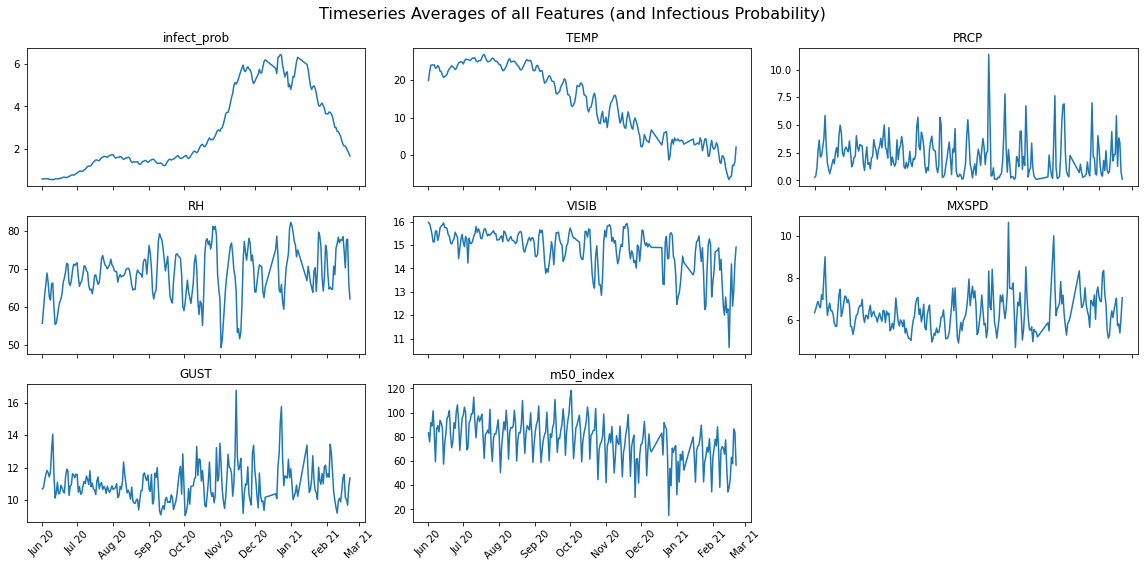

In [21]:
df_avg = df.groupBy('YEARMODA').agg(F.avg('TEMP'), F.avg('infect_prob'), F.avg('PRCP'),
                                   F.avg('VISIB'), F.avg('MXSPD'), F.avg('GUST'),
                                   F.avg('RH'), F.avg('m50_index')).toPandas()
df_avg.columns = ['date','TEMP','infect_prob', 'PRCP', 'VISIB', 'MXSPD','GUST','RH', 'm50_index']
df_avg.date = pd.to_datetime(df_avg.date)
df_avg = df_avg.sort_values(by = 'date')

fig, ax = plt.subplots(3, 3, figsize = (16, 8), sharey = False, sharex = True)
fig.autofmt_xdate(bottom=0.2, rotation=45, ha='center')

ax[0,0].plot(df_avg.date, df_avg.infect_prob)
ax[0,0].set_title('infect_prob')
ax[0,1].plot(df_avg.date, df_avg.TEMP)
ax[0,1].set_title('TEMP')
ax[0,2].plot(df_avg.date, df_avg.PRCP)
ax[0,2].set_title('PRCP')
ax[1,0].plot(df_avg.date, df_avg.RH)
ax[1,0].set_title('RH')
ax[1,1].plot(df_avg.date, df_avg.VISIB)
ax[1,1].set_title('VISIB')
ax[1,2].plot(df_avg.date, df_avg.MXSPD)
ax[1,2].set_title('MXSPD')
ax[2,0].plot(df_avg.date, df_avg.GUST)
ax[2,0].set_title('GUST')
ax[2,1].plot(df_avg.date, df_avg.m50_index)
ax[2,1].set_title('m50_index')
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
fig.delaxes(ax[2,2])

fig.suptitle("Timeseries Averages of all Features (and Infectious Probability)", fontsize=16)
plt.tight_layout()

plt.savefig('ts_plots.png', dpi=300, facecolor = 'w', transparent = False)

## 4. Model Construction

### 4.1 Initial Model Selection

Our first task is to determine what class of models gives us the best results.  We'll use Root Mean Squared Error (RMSE) and $R^2$ to compare performance because we are using all regression techniques (as we have a continuous dependent variable).  

In [22]:
model_df = pd.DataFrame()

#### 4.1.1 Regression (simplest model)

In [23]:
lr_mod = GeneralizedLinearRegression(labelCol = 'infect_prob_7day_lag', featuresCol = 'scaled_features')
lr = lr_mod.fit(train)
pred = lr.transform(test)

evaluator = RegressionEvaluator(labelCol = 'infect_prob_7day_lag', predictionCol = 'prediction', metricName = 'rmse')
rmse = evaluator.evaluate(pred)

evaluator2 = RegressionEvaluator(labelCol = 'infect_prob_7day_lag', predictionCol = 'prediction', metricName = 'r2')
R2 = evaluator2.evaluate(pred)

model_df['model'] = ['Linear Regression']
model_df['rmse'] = [rmse]
model_df['R2'] = [R2]

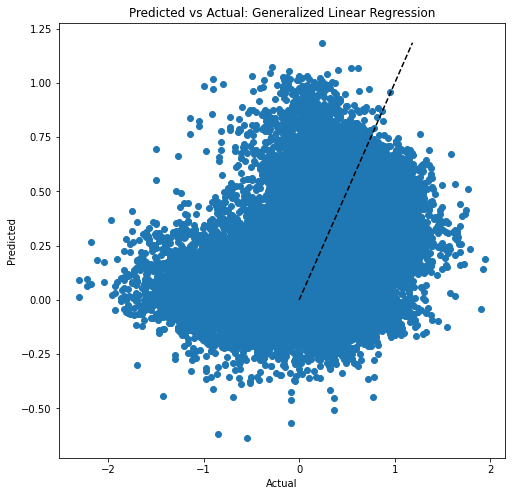

In [24]:
actual  = np.array(pred.select("infect_prob_7day_lag").collect())
predicted = np.array(pred.select("prediction").collect())
plt.figure(figsize=(8,8))
plt.plot([0,predicted.max()],[0, predicted.max()], color = 'k', ls='--') # Diag. Line
plt.scatter(actual, predicted )
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual: Generalized Linear Regression")
plt.show()

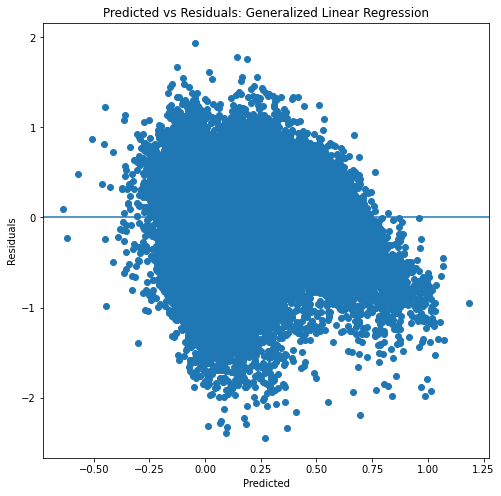

In [25]:
plt.figure(figsize=(8,8))
plt.scatter(predicted, actual - predicted )
plt.axhline(0)
plt.ylabel("Residuals")
plt.xlabel("Predicted")
plt.title("Predicted vs Residuals: Generalized Linear Regression")
plt.show()

#### 4.1.2 Random Forest

In [26]:
mod = RandomForestRegressor(labelCol = 'infect_prob_7day_lag', featuresCol = 'scaled_features')
rf = mod.fit(train)
pred = rf.transform(test)

evaluator = RegressionEvaluator(labelCol = 'infect_prob_7day_lag', predictionCol = 'prediction', metricName = 'rmse')
rmse = evaluator.evaluate(pred)

evaluator2 = RegressionEvaluator(labelCol = 'infect_prob_7day_lag', predictionCol = 'prediction', metricName = 'r2')
R2 = evaluator2.evaluate(pred)

model_df = model_df.append({'model': 'Random Forest', 'rmse': rmse , 'R2' : R2}, ignore_index=True)

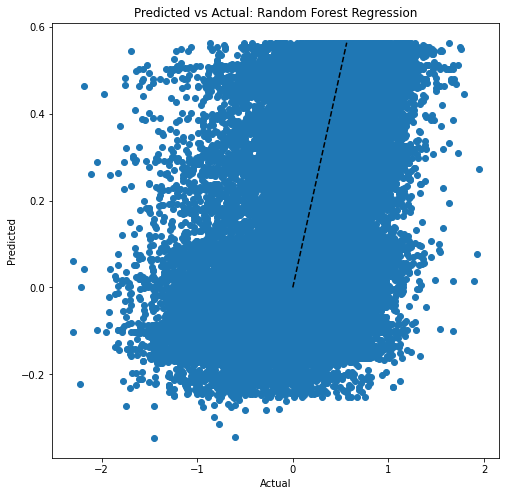

In [27]:
actual  = np.array(pred.select("infect_prob_7day_lag").collect())
predicted = np.array(pred.select("prediction").collect())
plt.figure(figsize=(8,8))
plt.scatter(actual, predicted )
plt.plot([0,predicted.max()],[0, predicted.max()], color = 'k', ls='--') # Diag. Line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual: Random Forest Regression")
plt.show()

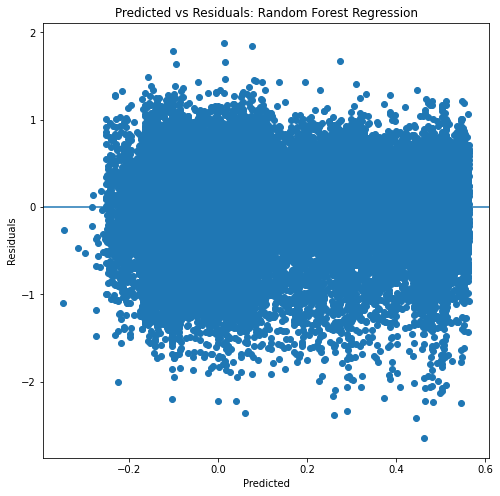

In [28]:
plt.figure(figsize=(8,8))
plt.scatter(predicted, actual - predicted )
plt.axhline(0)
plt.ylabel("Residuals")
plt.xlabel("Predicted")
plt.title("Predicted vs Residuals: Random Forest Regression")
plt.show()

#### 4.1.3 Gradient Boosted Trees

In [29]:
mod = GBTRegressor(labelCol = 'infect_prob_7day_lag', featuresCol = 'scaled_features')
lr = mod.fit(train)
pred = lr.transform(test)

evaluator = RegressionEvaluator(labelCol = 'infect_prob_7day_lag', predictionCol = 'prediction', metricName = 'rmse')
rmse = evaluator.evaluate(pred)

evaluator2 = RegressionEvaluator(labelCol = 'infect_prob_7day_lag', predictionCol = 'prediction', metricName = 'r2')
R2 = evaluator2.evaluate(pred)

model_df = model_df.append({'model': 'GBT', 'rmse': rmse, 'R2' : R2}, ignore_index=True)

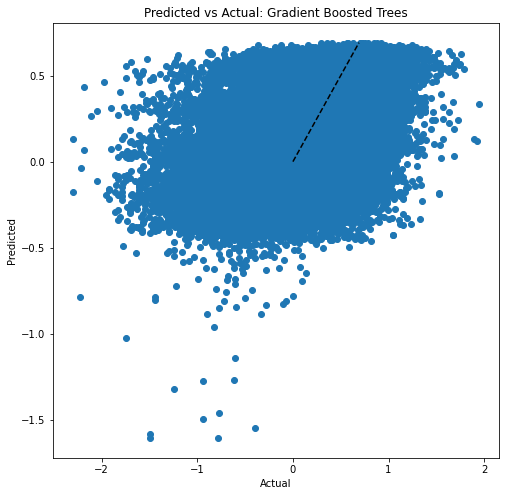

In [30]:
actual  = np.array(pred.select("infect_prob_7day_lag").collect())
predicted = np.array(pred.select("prediction").collect())
plt.figure(figsize=(8,8))
plt.scatter(actual, predicted )
plt.plot([0,predicted.max()],[0, predicted.max()], color = 'k', ls='--') # Diag. Line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual: Gradient Boosted Trees")
plt.show()

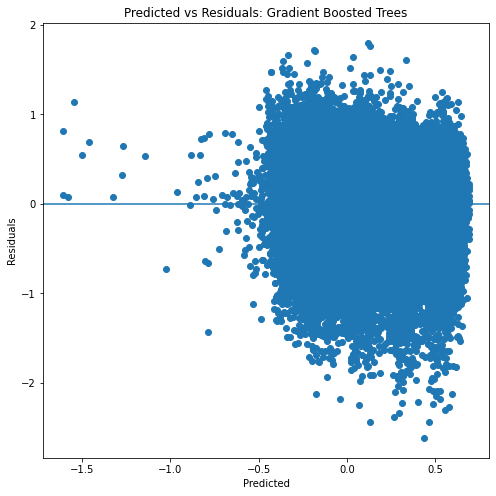

In [31]:
plt.figure(figsize=(8,8))
plt.scatter(predicted, actual - predicted )
plt.axhline(0)
plt.ylabel("Residuals")
plt.xlabel("Predicted")
plt.title("Predicted vs Residuals: Gradient Boosted Trees")
plt.show()

#### 4.1.4 Decision Tree Regression

In [32]:
mod = DecisionTreeRegressor(labelCol = 'infect_prob_7day_lag', featuresCol = 'scaled_features')
lr = mod.fit(train)
pred = lr.transform(test)

evaluator = RegressionEvaluator(labelCol = 'infect_prob_7day_lag', predictionCol = 'prediction', metricName = 'rmse')
rmse = evaluator.evaluate(pred)

evaluator2 = RegressionEvaluator(labelCol = 'infect_prob_7day_lag', predictionCol = 'prediction', metricName = 'r2')
R2 = evaluator2.evaluate(pred)

model_df = model_df.append({'model': 'Decision Tree Regressor', 'rmse': rmse, 'R2' : R2}, ignore_index=True)

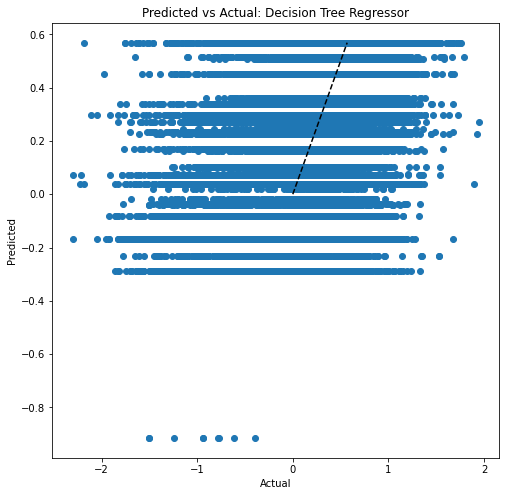

In [33]:
actual  = np.array(pred.select("infect_prob_7day_lag").collect())
predicted = np.array(pred.select("prediction").collect())
plt.figure(figsize=(8,8))
plt.scatter(actual, predicted )
plt.plot([0,predicted.max()],[0, predicted.max()], color = 'k', ls='--') # Diag. Line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual: Decision Tree Regressor")
plt.show()

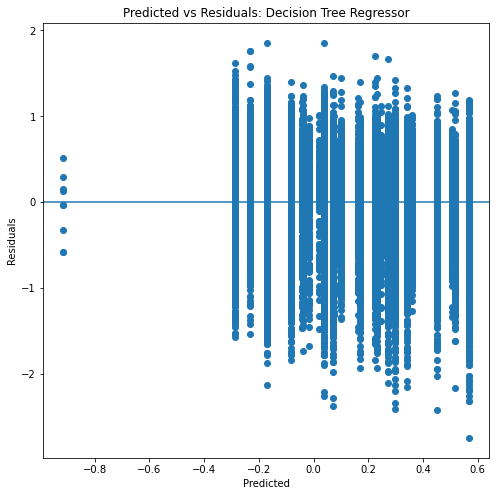

In [34]:
plt.figure(figsize=(8,8))
plt.scatter(predicted, actual - predicted )
plt.axhline(0)
plt.ylabel("Residuals")
plt.xlabel("Predicted")
plt.title("Predicted vs Residuals: Decision Tree Regressor")
plt.show()

In [35]:
model_df

,model,rmse,R2
0,Linear Regression,0.475824,0.189371
1,Random Forest,0.442899,0.297672
2,GBT,0.432095,0.331522
3,Decision Tree Regressor,0.441323,0.302663


## 4.2 Model Evaluation Discussion and Champion Selection

The GBT model had the best performance in terms of RMSE and $R^2$.  We expected the tree models to outperform linear regression given the large number of variables and lack of clear linear relationships in our initial evaluation.  It was surprising that GBT outperformed the other tree-based models to the degree that it did.

It is clear from the above plots and the RMSE/$R^2$ results that there is significant variation in infectious probability that is not accounted for by our models.  We expected this to be the case given the large number of omitted variables that likely affect COVID-19 spread.  We were, however, satisfied that our models have some predictive ability even when just including weather and mobility data.

## 4.3 Tuning Hyperparameters for GBT (Champion Model)

The best peformance seems to be from GBT.  Given additional time, we would probably want to tune hyperparemeters for all of these models to see if we can get improvements, but for something with the scope of this project, we will continue with GBT as our champion model.

The hyperparameters we will look at are the maximum iterations and max depth of the trees.  Again, we would probably explore a larger grid if given access to more computing power.  We will focus on a robust set of parameters (3 different max iterations and 2 different max depths) that is small enough to run in a reasonable amount of time with our available resources.

source: https://docs.azuredatabricks.net/_static/notebooks/gbt-regression.html

Note, the below code takes a long time to run.  You may need to modify `setParallelism()` based on your own hardware.

In [36]:
mod = GBTRegressor(labelCol = 'infect_prob_7day_lag', featuresCol = 'scaled_features')
evaluator = RegressionEvaluator(labelCol = 'infect_prob_7day_lag', predictionCol = 'prediction', metricName = 'rmse')
evaluator2 = RegressionEvaluator(labelCol = 'infect_prob_7day_lag', predictionCol = 'prediction', metricName = 'r2')


paramGrid = ParamGridBuilder() \
    .addGrid(mod.maxIter, [10, 50, 100]) \
    .addGrid(mod.maxDepth, [2, 5]) \
    .build()

crossval = CrossValidator(estimator=mod,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=4)

cvModel = crossval.setParallelism(20).fit(train)
predictions = cvModel.transform(test)

In [37]:
best_mod = cvModel.bestModel

best_mod.getOrDefault('maxIter')

100

In [38]:
best_mod.getOrDefault('maxDepth')

5

In [39]:
rmse = evaluator.evaluate(predictions)
rmse

0.42645142196999897

In [40]:
r2 = evaluator2.evaluate(predictions)
r2

0.34886828290534255

100 max iterations and 5 depth seem to produce the best results.  As mentioned above, we might want to explore even more iterations or depths.  We ran a few tests with larger values in separate notebooks.  Some of these runs took multiple days to complete and resulted in modest gains to RMSE and $R^2$.  The values we found here seem to balance computation time and quality well.

## 4.4 Train Champion Model on Full Dataset

Because we're down to a single model with set parameters, we can now run over the full dataset without creating too much computational burden.

In [41]:
train, test = df_scaled.randomSplit([0.7, 0.3])

mod = GBTRegressor(labelCol = 'infect_prob_7day_lag', featuresCol = 'scaled_features',
                   maxIter = best_mod.getOrDefault('maxIter'), maxDepth = best_mod.getOrDefault('maxDepth'))
lr = mod.fit(train)
pred = lr.transform(test)

evaluator = RegressionEvaluator(labelCol = 'infect_prob_7day_lag', predictionCol = 'prediction', metricName = 'rmse')
rmse = evaluator.evaluate(pred)

evaluator2 = RegressionEvaluator(labelCol = 'infect_prob_7day_lag', predictionCol = 'prediction', metricName = 'r2')
r2 = evaluator2.evaluate(pred)

In [42]:
rmse

0.4258171758196169

In [43]:
r2

0.34935809198657175

We find the RMSE and $R^2$ values to be similar to those we found when tuning hyperparameters and using cross validation.

## 5. Final Model Evaluation and Prediction

### 5.1 Feature Importance

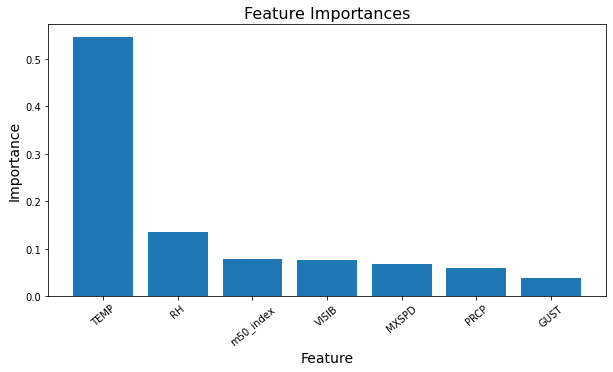

In [44]:
imp_df = pd.DataFrame({'importance': lr.featureImportances, 'features': features})
imp_df = imp_df.sort_values(by = 'importance', ascending=False)
x_values = list(range(len(imp_df.importance)))

plt.figure(figsize = (10, 5))

plt.bar(x_values, imp_df.importance, orientation = 'vertical')
plt.xticks(x_values, imp_df.features, rotation=40)
plt.ylabel('Importance', fontsize = 14)
plt.xlabel('Feature', fontsize = 14)
plt.title('Feature Importances', fontsize = 16);

plt.savefig('feature_importance.png', dpi=300, facecolor = 'w', transparent = False)

It looks like tempurature is by far the most important features in our GPT model.  We expected that mobility (MXSPD) would have a much greater effect.  It seems like we have some evidence that temperature is important variable in the spread of COVID, even beyond the fact that mobility is affected by temperature. 

### 5.2 Making Predictions

In [45]:
chicago = pred.filter(pred.FIPS == '17031')
chicago = chicago.toPandas()
chicago.YEARMODA = pd.to_datetime(chicago.YEARMODA)

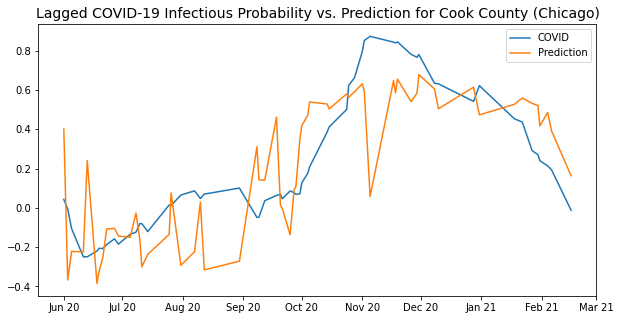

In [46]:
fig, ax = plt.subplots(figsize = (10, 5))

ax.plot(chicago.YEARMODA, chicago.infect_prob_7day_lag, label = 'COVID')
ax.plot(chicago.YEARMODA, chicago.prediction, label = 'Prediction')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
ax.legend()
ax.set_title(label = 'Lagged COVID-19 Infectious Probability vs. Prediction for Cook County (Chicago)', fontsize = 14)

plt.savefig('chicago_predict.png', dpi=300, facecolor = 'w', transparent = False)

It is clear that our method is causing predictions that jump around quite a bit.  We also notably lag the spike by a bit, but we do everntually catch up.  This is likely due to the fact that our model doesn't consider time in any meaningful way.  There are some timeseries approaches that I've been reading about, but many of them do not appear to be implemented in Pyspark.  This is definitely in the "future work" category, in my opinion.  Our model makes predictions that are somewhat erratic, but still interesting.  Moreover, we were more interested in using this as a kind of screening experiment ot see if weather features were related to COVID-19 spread - accurate prediction wasn't ever really the goal.  I think we have more than enough here to suggest COVID and temperature might be related in a way that goes beyond people tending to move around more in warmer temperatures.

Also in "future work", I think this problem would benefit from a hierarchical modeling framework like the ones that they teach in the Bayesian ML course in this department.  The idea would be to have some commonality in the parameters that cause COVID to spread, but allow those to vary across the different counties to some degree to account for things like different attitudes toward the pandemic across the country.  It is important to note that the Bayesian methods are very computationally intensive and data of this size may not work well there either.  I'm not aware of hierarchical methods available in Pyspark, but it could be worth looking into.

Another thing I would want to explore is deeper trees.  We ran into some computational hurdles with the timeline of this project that limited the depth of tree we were able to explore.  It seems like we're getting pretty marginal returns to increases in max tree depth that are not worth the extra computation time, but for a true study, it would be worth exploring this further.  With access to a better clustering system (e.g., AWS EMR), it might be more practical to explore these hyperparameter spaces.